In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
import codecs

# 1. read file
with codecs.open("data/all_scripts.txt", encoding="utf8") as f:
    script_lines = f.read().splitlines()
print(script_lines[:10])

['>> Series 01 Episode 01 – Pilot\xa0Episode', '> A corridor at a sperm bank.', 'Sheldon: So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.', 'Leonard: Agreed, what’s your point?', 'Sheldon: There’s no point, I just think it’s a good idea for a tee-shirt.', 'Leonard: Excuse me?', 'Receptionist: Hang on.', 'Leonard: One across is Aegean, eight down is Nabakov, twenty-six across is MCM, fourteen down is… move your finger… phylum, which makes fourteen across Port-au-Prince. See, Papa Doc’s capital idea, that’s Port-au-Prince. Haiti.', 'Receptionist: Can I help you?', 'Leonard: Yes. Um, is this the High IQ sperm bank?']


In [3]:
# 2. iterate and organise
episodes = []
scenes = []
characters = []
dialogues = []

episode = None
scene = None
for line in script_lines:
    if line.startswith(">>"):
        episode = line[2:].strip()
        scene = None
    elif line.startswith(">"):
        assert episode is not None
        scene = line[1:].strip()
    else:
        assert episode is not None and scene is not None

        character, dialogue = line.split(":", 1)
        character = character.strip()
        dialogue = dialogue.strip()

        if character.lower() in ["all", "together", "everybody", "everyone"]:
            continue

        episodes.append(episode)
        scenes.append(scene)
        characters.append(character)
        dialogues.append(dialogue)

scripts = pd.DataFrame({
    "episode": episodes,
    "scene": scenes,
    "character": characters,
    "text": dialogues
})
scripts.head()

,episode,scene,character,text
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


In [4]:
# 3. explore characters to make sure there are no casefolding problems
scripts.character.value_counts()

# looks good.

Sheldon              11689
Leonard               9829
Penny                 7677
Howard                5872
Raj                   4779
                     ...  
Hernandez                3
Mrs. Rostenkowski        3
Guard                    3
First Girl               3
Bill                     3
Name: character, Length: 195, dtype: int64

In [5]:
# 4. explore episodes
scripts.episode.value_counts()

# Looks good.

Series 01 Episode 01 – Pilot Episode                                320
Series 01 Episode 07 – The Dumpling Paradox                         283
Series 04 Episode 03 – The Zazzy Substitution                       271
Series 10 Episode 01 – The Conjugal Conjecture                      269
Series 09 Episode 22 – The Fermentation Bifurcation                 263
                                                                   ... 
Series 05 Episode 14 – The Beta Test Initiation                     169
Series 03 Episode 13 – The Bozeman Reaction                         165
Series 03 Episode 18 – The Pants Alternative                        160
Series 06 Episode 17 – The Monster Isolation                        160
Series 06 Episode 18 – The Contractual Obligation Implementation    141
Name: episode, Length: 231, dtype: int64

In [6]:
# 5. get the season, preprocess episode
scripts["season"] = scripts.episode.apply(lambda s: s.split("Episode")[0].strip().split("Series")[1].strip()).astype(int)
scripts.sample(10)

,episode,scene,character,text,season
10220,Series 03 Episode 04 – The Pirate Solution,Sheldon’s office. Sheldon is writing on the wh...,Raj,Come and get it.,3
39962,Series 08 Episode 23 – The Maternal Combustion,A coffee shop.,Sheldon,"Well, you doled out affection as a reward for ...",8
35655,Series 08 Episode 04 – The Hook-Up Reverbration,The apartment.,Bernadette,"Long story short, they have seven HBOs.",8
18670,Series 04 Episode 19 – The Zarnecki Incursion,The apartment,Priya,"Oh, dear Lord.",4
798,Series 01 Episode 04 – The Luminous Fish Effect,Sheldon and Leonard’s apartment.,Sheldon,I’ve been thinking about time travel again.,1
17766,Series 04 Episode 15 – The Benefactor Factor,The apartment.,Sheldon,"I must confess I don’t understand you, Preside...",4
41627,Series 09 Episode 07 – The Spock Resonance,Howard and Bernadette’s kitchen.,Howard,"No way. No, this is the room I associate the m...",9
44314,Series 09 Episode 19 – The Solder Excursion Di...,Howard’s workshop.,Bernadette,It is crazy. It’s also crazy that I’ve made fo...,9
19519,Series 04 Episode 23 – The Engagement Reaction,The Cheesecake Factory,Bernadette,You guys ready to order?,4
24739,Series 05 Episode 24 – The Countdown Reflection,The apartment.,Sheldon,"Oh, dear. I was afraid of this.",5


In [7]:
# 6. scenes per season NOT PER EPISODE!
seasons = list(sorted(scripts.season.value_counts().index))
scenes_per_season = pd.DataFrame({
    "season": seasons,
    "scenes": np.zeros(len(seasons))
})
scenes_per_season = scenes_per_season.set_index("season")

scene = None
season = None
for _, row in scripts.iterrows():
    if season != row.season:
        season = row.season
        scene = row.scene
        scenes_per_season.at[season, "scenes"] += 1
    elif row.scene != scene:
        scene = row.scene
        scenes_per_season.at[season, "scenes"] += 1

scenes_per_season

,scenes
season,
1,159.0
2,231.0
3,235.0
4,278.0
5,254.0
6,304.0
7,331.0
8,323.0
9,331.0


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [8]:
# 1. counts
char_counts = scripts.character.value_counts()
recurrent_characters_with_counts = char_counts[char_counts > 90]
recurrent_characters_with_counts

Sheldon         11689
Leonard          9829
Penny            7677
Howard           5872
Raj              4779
Amy              3472
Bernadette       2690
Stuart            733
Priya             222
Mrs Cooper        213
Emily             164
Beverley          162
Mrs Wolowitz      136
Zack              135
Arthur            130
Wil               126
Leslie            116
Kripke            106
Man               105
Bert               95
Name: character, dtype: int64

In [9]:
# 2. recurrent minus "Man"
recurrent_characters = list(recurrent_characters_with_counts.index)
assert len(recurrent_characters) == 20
recurrent_characters.remove("Man")
assert len(recurrent_characters) == 19
recurrent_characters

['Sheldon',
 'Leonard',
 'Penny',
 'Howard',
 'Raj',
 'Amy',
 'Bernadette',
 'Stuart',
 'Priya',
 'Mrs Cooper',
 'Emily',
 'Beverley',
 'Mrs Wolowitz',
 'Zack',
 'Arthur',
 'Wil',
 'Leslie',
 'Kripke',
 'Bert']

In [17]:
# 3. filter dialogues
scripts = scripts[scripts.character.isin(recurrent_characters)]
assert len(scripts.character.value_counts()) == 19
scripts.head(20)

,episode,scene,character,text,season
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...,1
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?",1
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide...",1
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?,1
5,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"One across is Aegean, eight down is Nabakov, t...",1
7,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Yes. Um, is this the High IQ sperm bank?",1
9,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,I think this is the place.,1
11,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Thank-you. We’ll be right back.,1
13,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"Leonard, I don’t think I can do this.",1
14,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"What, are you kidding? You’re a semi-pro.",1


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [28]:
# 1. prepare excludor
from helpers.helper_functions import  EXCLUDE_CHARS

def exclude_chars(text, exclude_chars_list):
    for c in exclude_chars_list:
        text = text.replace(c, " ")
    return text

print(dialogue)
print(exclude_chars(dialogue, EXCLUDE_CHARS))

(Knock, knock, knock) Amy. (Knock, knock, knock) Amy. (Knock, knock, knock) Amy. Will you marry me?
 Knock  knock  knock  Amy   Knock  knock  knock  Amy   Knock  knock  knock  Amy  Will you marry me 


In [31]:
# 2. apply
scripts.text = scripts.text.apply(lambda t: exclude_chars(t, EXCLUDE_CHARS)).apply(str.lower)
scripts.head(10)

,episode,scene,character,text,season
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...,1
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point,1
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...,1
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me,1
5,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,one across is aegean eight down is nabakov t...,1
7,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,yes um is this the high iq sperm bank,1
9,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,i think this is the place,1
11,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,thank you we ll be right back,1
13,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,leonard i don t think i can do this,1
14,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,what are you kidding you re a semi pro,1


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [72]:
# 1. count words occurances in corups aka in all dialoges in all scenes
from collections import Counter
word_freq = Counter([word for text in scripts.text.array for word in text.split()])
common_words = word_freq.most_common()
counts = np.array(list(word_freq.values()))
assert len(word_freq.values()) == len(common_words) == len(counts)

print(f"Words: {len(word_freq)}")
print(f"Top 30 most common:\n{common_words[:30]}")

Words: 21102
Top 30 most common:
[('i', 24764), ('you', 22977), ('the', 15110), ('to', 14295), ('a', 13518), ('s', 12105), ('it', 11182), ('and', 8784), ('that', 8526), ('t', 7617), ('of', 7335), ('in', 5676), ('is', 5444), ('we', 5293), ('what', 5206), ('me', 4905), ('my', 4810), ('m', 4797), ('on', 4297), ('re', 4105), ('oh', 4098), ('this', 4080), ('with', 3945), ('have', 3907), ('no', 3814), ('not', 3762), ('for', 3748), ('your', 3604), ('know', 3505), ('do', 3456)]


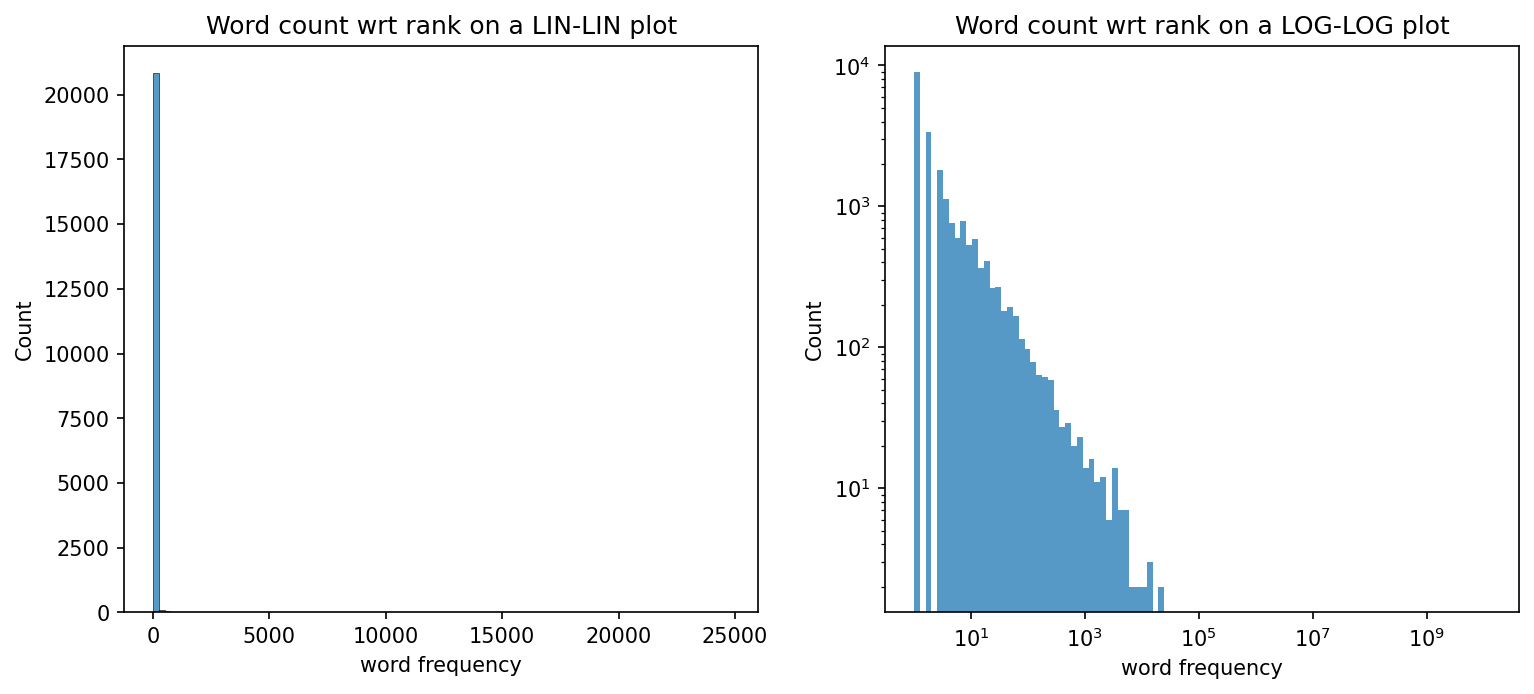

In [74]:
# 2. its a power law of course
import  seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), dpi=150)

for ax in (ax1, ax2):
    ax.set_xlabel("word rank")
    ax.set_xlabel("word frequency")

ax1.set_title("Word count wrt rank on a LIN-LIN plot")
sns.histplot(x=counts, bins=100, ax=ax1)
# sns.scatterplot(x=range(1, len(common_words)+1), y=[wc[1] for wc in common_words], ax=ax1)

ax2.set_title("Word count wrt rank on a LOG-LOG plot")
sns.histplot(x=counts, bins=np.logspace(np.log(counts.min()), np.log(counts.max()), 100), ax=ax2)
ax2.set_xscale("log")
ax2.set_yscale("log")


In [ ]:
"Yes, this is a power law"

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [78]:
utterances = []
for character in recurrent_characters:
    u = scripts[scripts.character == character].text.apply(lambda t: len(t.split())).sum()
    utterances.append((u, character))
for i, (u, c) in enumerate(reversed(sorted(utterances))):
    print(f"{c} uttered {u} words {'***WINNER***' if i == 0 else ''}")

Sheldon uttered 185388 words ***WINNER***
Leonard uttered 102496 words 
Penny uttered 79270 words 
Howard uttered 69505 words 
Raj uttered 60099 words 
Amy uttered 39933 words 
Bernadette uttered 27726 words 
Stuart uttered 7955 words 
Mrs Cooper uttered 3389 words 
Beverley uttered 2029 words 
Priya uttered 1940 words 
Wil uttered 1678 words 
Emily uttered 1571 words 
Mrs Wolowitz uttered 1459 words 
Arthur uttered 1451 words 
Zack uttered 1427 words 
Leslie uttered 1249 words 
Kripke uttered 1246 words 
Bert uttered 1146 words 


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [14]:
100 minutes so far :-(

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [15]:
# your code goes here